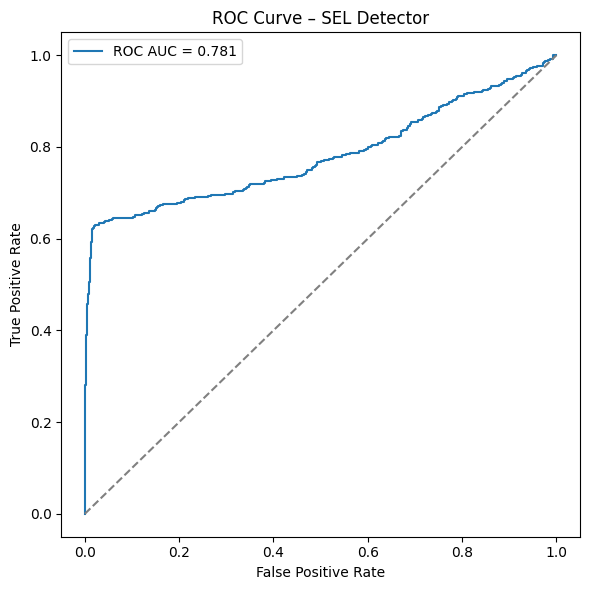

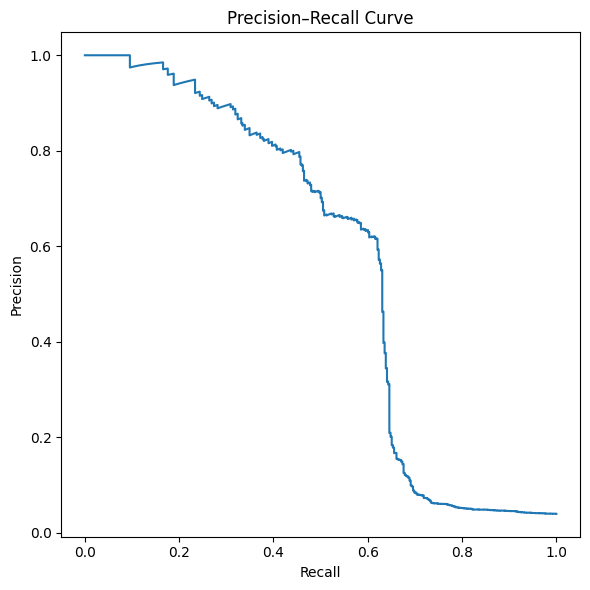

Best F1-threshold: 0.5867 | F1=0.618
Stored threshold from training: 0.6023
Using threshold for evaluation: 0.6023
Confusion Matrix:
 [[9504   96]
 [ 197  201]]

Classification Report:
               precision    recall  f1-score   support

           0       0.98      0.99      0.98      9600
           1       0.68      0.51      0.58       398

    accuracy                           0.97      9998
   macro avg       0.83      0.75      0.78      9998
weighted avg       0.97      0.97      0.97      9998

Average detection latency: 147.80 ms (max 404.00 ms)


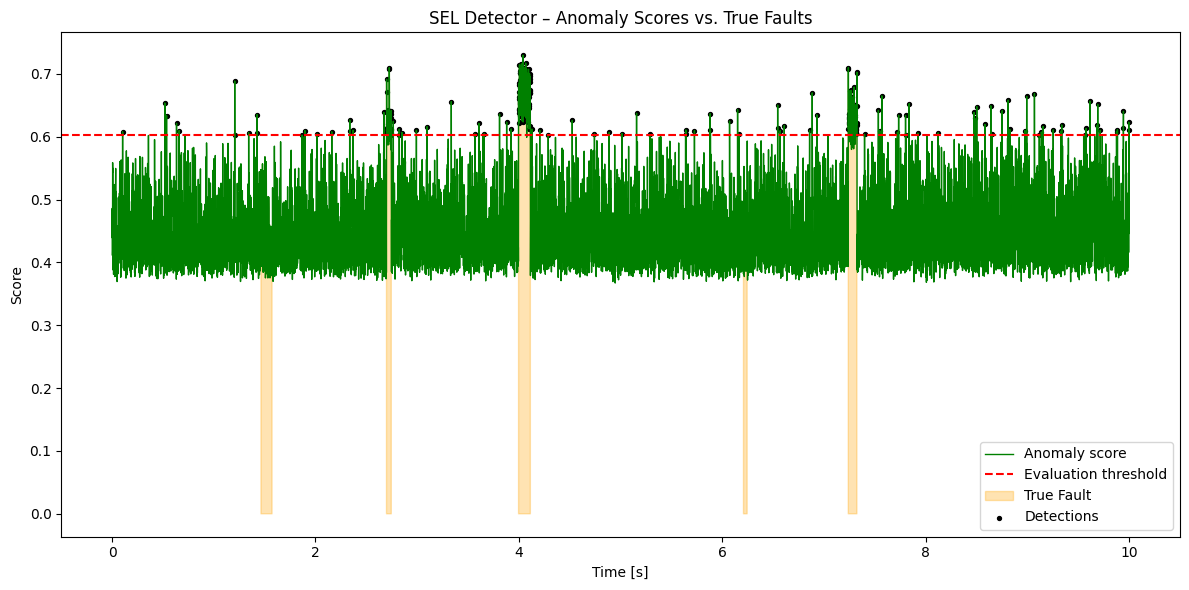

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import (
    confusion_matrix, classification_report,
    roc_curve, auc, precision_recall_curve
)
import joblib

# -----------------------------
# Load model + data
# -----------------------------
pack = joblib.load("../models/iforest_model.pkl")
pipe = pack["pipe"]
threshold_saved = pack.get("threshold")

df_feat = pd.read_csv("../data/cubesat_features.csv")

FEATURES = ["dI_dt", "Vout_droop", "ripple_RMS", "efficiency", "dEff_dT"]
X = df_feat[FEATURES].to_numpy(dtype=np.float32, copy=False)

# -----------------------------
# Generate anomaly scores
# -----------------------------
scores = -pipe.score_samples(X)
df_feat["anomaly_score"] = scores

# -----------------------------
# Evaluate various thresholds
# -----------------------------
y_true = df_feat["fault_label"].to_numpy()

# 1) ROC curve
fpr, tpr, thr = roc_curve(y_true, scores)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6,6))
plt.plot(fpr, tpr, label=f"ROC AUC = {roc_auc:.3f}")
plt.plot([0,1],[0,1],'--',color='gray')
plt.xlabel("False Positive Rate"); plt.ylabel("True Positive Rate")
plt.title("ROC Curve – SEL Detector")
plt.legend(); plt.tight_layout(); plt.show()

# 2) Precision–Recall curve
prec, rec, thr_pr = precision_recall_curve(y_true, scores)
plt.figure(figsize=(6,6))
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision–Recall Curve")
plt.tight_layout(); plt.show()

# -----------------------------
# Pick optimal threshold (F1 max)
# -----------------------------
f1_scores = 2 * prec * rec / (prec + rec + 1e-9)
if thr_pr.size:
    best_idx = np.argmax(f1_scores[:-1])
    threshold_opt = thr_pr[best_idx]
    best_f1 = f1_scores[best_idx]
else:
    threshold_opt = threshold_saved if threshold_saved is not None else 0.0
    best_f1 = f1_scores[0]
print(f"Best F1-threshold: {threshold_opt:.4f} | F1={best_f1:.3f}")
if threshold_saved is not None:
    print(f"Stored threshold from training: {threshold_saved:.4f}")
threshold_eval = threshold_saved if threshold_saved is not None else threshold_opt
print(f"Using threshold for evaluation: {threshold_eval:.4f}")

df_feat["predicted_fault"] = (df_feat["anomaly_score"] > threshold_eval).astype(int)

# -----------------------------
# Confusion matrix & metrics
# -----------------------------
cm = confusion_matrix(y_true, df_feat["predicted_fault"])
print("Confusion Matrix:\n", cm)
print("\nClassification Report:\n", classification_report(y_true, df_feat["predicted_fault"]))

# -----------------------------
# Detection latency estimation
# -----------------------------
fs = 10_000
window_ms = 2
time_step = window_ms/2/1000  # 50% overlap = 1 ms steps

det_latencies = []
if y_true.size:
    fault_starts = np.where(np.diff(y_true, prepend=y_true[0]) == 1)[0]
else:
    fault_starts = np.array([], dtype=int)
for start_idx in fault_starts:
    # find first detection after start
    detections = np.where(df_feat.loc[start_idx:, "predicted_fault"].to_numpy() == 1)[0]
    if detections.size:
        idx_detect = start_idx + detections[0]
        latency = (idx_detect - start_idx) * time_step * 1000  # ms
        det_latencies.append(latency)

if det_latencies:
    print(f"Average detection latency: {np.mean(det_latencies):.2f} ms "
          f"(max {np.max(det_latencies):.2f} ms)")
else:
    print("No detected faults after true fault onsets; latency not computed.")

# -----------------------------
# Visual validation
# -----------------------------
plt.figure(figsize=(12,6))
plt.plot(df_feat["time_s"], df_feat["anomaly_score"], label="Anomaly score", lw=1,color="green")
plt.axhline(threshold_eval, color="r", linestyle="--", label="Evaluation threshold")
plt.fill_between(df_feat["time_s"], 0, df_feat["anomaly_score"],
                 where=df_feat["fault_label"]==1, color="orange", alpha=0.3, label="True Fault")
plt.scatter(df_feat.loc[df_feat["predicted_fault"]==1,"time_s"],
            df_feat.loc[df_feat["predicted_fault"]==1,"anomaly_score"],
            color="black", s=8, label="Detections")
plt.title("SEL Detector – Anomaly Scores vs. True Faults")
plt.xlabel("Time [s]"); plt.ylabel("Score")
plt.legend(); plt.tight_layout(); plt.show()